In [6]:
# !pip3 install lime

In [1]:
import re
import nltk
import string
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer, WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Dense, LSTM, Embedding, Bidirectional
from wordcloud import WordCloud
# from nltk.corpus import stopwords
# from nltk.stem import WordNetLemmatizer

#nltk.download("stopwords")
stop_words = set(stopwords.words("english"))
lemmatizer= WordNetLemmatizer()


# Modelling
from sklearn.model_selection import train_test_split,KFold, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score,confusion_matrix, classification_report
from sklearn.pipeline import Pipeline
from sklearn.metrics import f1_score
from sklearn.svm import SVC

#Lime libraries
from lime import lime_text
from lime.lime_text import LimeTextExplainer
from lime.lime_text import IndexedString,IndexedCharacters
from lime.lime_base import LimeBase
from lime.lime_text import explanation
sns.set(font_scale=1.3)
nltk.download('omw-1.4')



[nltk_data] Downloading package omw-1.4 to /home/santosh/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [2]:
df_train = pd.read_csv('/home/santosh/sentiment/train.txt', names=['Text', 'Emotion'], sep=';')
df_val = pd.read_csv('/home/santosh/sentiment/val.txt', names=['Text', 'Emotion'], sep=';')
df_test = pd.read_csv('/home/santosh/sentiment/test.txt', names=['Text', 'Emotion'], sep=';')

In [3]:
df_train.head()


,Text,Emotion
0,i didnt feel humiliated,sadness
1,i can go from feeling so hopeless to so damned...,sadness
2,im grabbing a minute to post i feel greedy wrong,anger
3,i am ever feeling nostalgic about the fireplac...,love
4,i am feeling grouchy,anger


In [4]:
print(df_train.shape)

(16000, 2)


In [5]:
df_test.head()

,Text,Emotion
0,im feeling rather rotten so im not very ambiti...,sadness
1,im updating my blog because i feel shitty,sadness
2,i never make her separate from me because i do...,sadness
3,i left with my bouquet of red and yellow tulip...,joy
4,i was feeling a little vain when i did this one,sadness


In [6]:
print(df_test.shape)

(2000, 2)


In [7]:
df_val.head()

,Text,Emotion
0,im feeling quite sad and sorry for myself but ...,sadness
1,i feel like i am still looking at a blank canv...,sadness
2,i feel like a faithful servant,love
3,i am just feeling cranky and blue,anger
4,i can have for a treat or if i am feeling festive,joy


In [8]:
print(df_val.shape)

(2000, 2)


In [9]:
df_train.Emotion.value_counts()

Emotion
joy         5362
sadness     4666
anger       2159
fear        1937
love        1304
surprise     572
Name: count, dtype: int64

In [10]:
df_train.Emotion.value_counts() / df_train.shape[0] *100

Emotion
joy         33.51250
sadness     29.16250
anger       13.49375
fear        12.10625
love         8.15000
surprise     3.57500
Name: count, dtype: float64

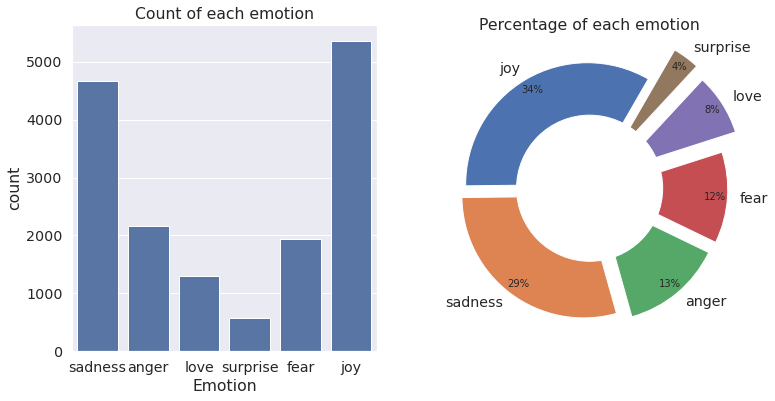

In [11]:
def plotting(df):
    col = 'Emotion'
    fig, (ax1, ax2)  = plt.subplots(nrows=1, ncols=2, figsize=(12,6))
    explode = list((np.array(list(df[col].dropna().value_counts()))/sum(list(df[col].dropna().value_counts())))[::-1])
    sizes = df[col].value_counts()
    labels = sizes.index
    #ax.pie(sizes, explode=explode, colors=bo, startangle=60, labels=labels,autopct='%1.0f%%', pctdistance=0.9)
    ax2.pie(sizes,  explode=explode, startangle=60, labels=labels,autopct='%1.0f%%', pctdistance=0.9)
    ax2.add_artist(plt.Circle((0,0),0.6,fc='white'))
    sns.countplot(x =col, data = df, ax=ax1)
    ax1.set_title("Count of each emotion")
    ax2.set_title("Percentage of each emotion")
    plt.show()

plotting(df_train)

In [12]:
df_train.isnull().sum()

Text       0
Emotion    0
dtype: int64

In [13]:
#print the number of duplicated values 
df_train.duplicated().sum()

1

In [14]:
#removing duplicated values
index = df_train[df_train.duplicated() == True].index
df_train.drop(index, axis = 0, inplace = True)
df_train.reset_index(inplace=True, drop = True)

In [15]:
#print the rows which are duplicated (duplicated in the text but with different emotions)
df_train[df_train['Text'].duplicated() == True]

,Text,Emotion
5067,i feel on the verge of tears from weariness i ...,joy
6133,i still feel a craving for sweet food,love
6563,i tend to stop breathing when i m feeling stre...,anger
7623,i was intensely conscious of how much cash i h...,sadness
7685,im still not sure why reilly feels the need to...,surprise
8246,i am not amazing or great at photography but i...,love
9596,ive also made it with both sugar measurements ...,joy
9687,i had to choose the sleek and smoother feel of...,joy
9769,i often find myself feeling assaulted by a mul...,sadness
9786,i feel im being generous with that statement,joy


In [16]:
#print some of those rows to check
df_train[df_train['Text'] == df_train.iloc[7623]['Text']]

,Text,Emotion
1625,i was intensely conscious of how much cash i h...,anger
7623,i was intensely conscious of how much cash i h...,sadness


In [17]:
df_train[df_train['Text'] == df_train.iloc[14313]['Text']]

,Text,Emotion
13653,i could feel myself hit this strange foggy wall,fear
14313,i could feel myself hit this strange foggy wall,surprise


In [18]:
df_train[df_train['Text'] == df_train.iloc[13879]['Text']]

,Text,Emotion
7333,i feel like i am very passionate about youtube...,joy
13879,i feel like i am very passionate about youtube...,love


In [19]:
#removing duplicated text 
index = df_train[df_train['Text'].duplicated() == True].index
df_train.drop(index, axis = 0, inplace = True)
df_train.reset_index(inplace=True, drop = True)

In [20]:
#Count the number of stopwords in the data
temp =df_train.copy()
stop_words = set(stopwords.words("english"))
temp['stop_words'] = temp['Text'].apply(lambda x: len(set(x.split()) & set(stop_words)))
temp.stop_words.value_counts()

stop_words
5     1416
7     1405
6     1392
4     1341
8     1319
3     1263
9     1177
10    1048
2      922
11     889
12     752
13     644
14     493
1      450
15     376
16     265
17     238
18     164
19     113
20      90
0       79
21      60
22      33
23      19
24       7
25       6
26       6
28       1
29       1
Name: count, dtype: int64

<Axes: ylabel='Frequency'>

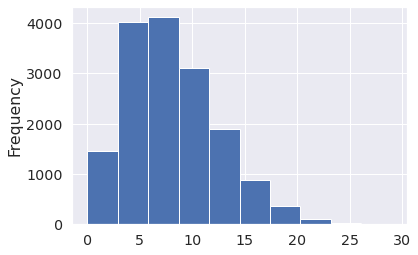

In [21]:
#distribution of stopwords visually
temp['stop_words'].plot(kind= 'hist')

In [22]:
#check if the data is balanced or not
df_test.Emotion.value_counts()

Emotion
joy         695
sadness     581
anger       275
fear        224
love        159
surprise     66
Name: count, dtype: int64

<Axes: xlabel='Emotion', ylabel='count'>

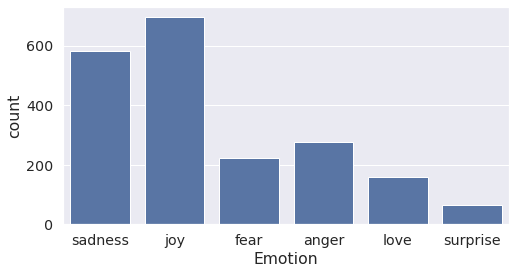

In [23]:
plt.figure(figsize=(8,4))
sns.countplot(x='Emotion', data=df_test)

In [24]:
#print the number of null values in each column
df_test.isnull().sum()

Text       0
Emotion    0
dtype: int64

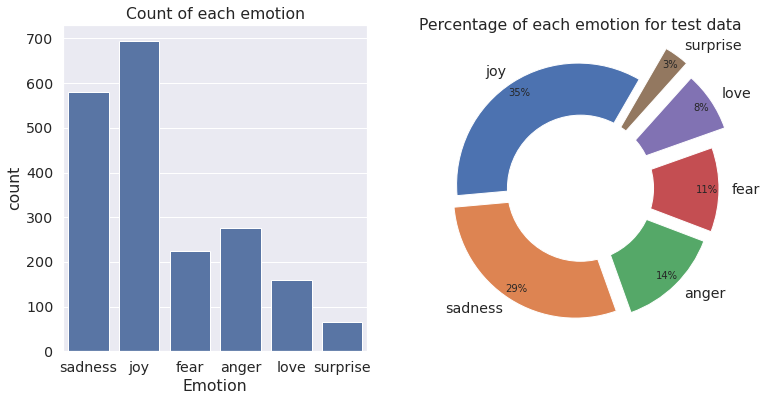

In [25]:
def plotting(df):
    col = 'Emotion'
    fig, (ax1, ax2)  = plt.subplots(nrows=1, ncols=2, figsize=(12,6))
    explode = list((np.array(list(df[col].dropna().value_counts()))/sum(list(df[col].dropna().value_counts())))[::-1])
    sizes = df[col].value_counts()
    labels = sizes.index
    #ax.pie(sizes, explode=explode, colors=bo, startangle=60, labels=labels,autopct='%1.0f%%', pctdistance=0.9)
    ax2.pie(sizes,  explode=explode, startangle=60, labels=labels,autopct='%1.0f%%', pctdistance=0.9)
    ax2.add_artist(plt.Circle((0,0),0.6,fc='white'))
    sns.countplot(x =col, data = df, ax=ax1)
    ax1.set_title("Count of each emotion")
    ax2.set_title("Percentage of each emotion for test data")
    plt.show()

plotting(df_test)

In [26]:
#Count the number of stopwords in the data
temp_test_df =df_test.copy()
temp_test_df['stop_words'] = temp_test_df['Text'].apply(lambda x: len(set(x.split()) & set(stop_words)))
temp_test_df.stop_words.value_counts()

stop_words
7     184
6     179
3     175
5     175
4     163
9     163
8     139
10    123
2     118
11    115
12     84
13     71
15     61
14     58
1      42
16     40
17     31
18     22
20     17
19     11
21     10
0       8
23      7
24      2
22      2
Name: count, dtype: int64

In [27]:
#check if the data is balanced or not
df_val.Emotion.value_counts()

Emotion
joy         704
sadness     550
anger       275
fear        212
love        178
surprise     81
Name: count, dtype: int64

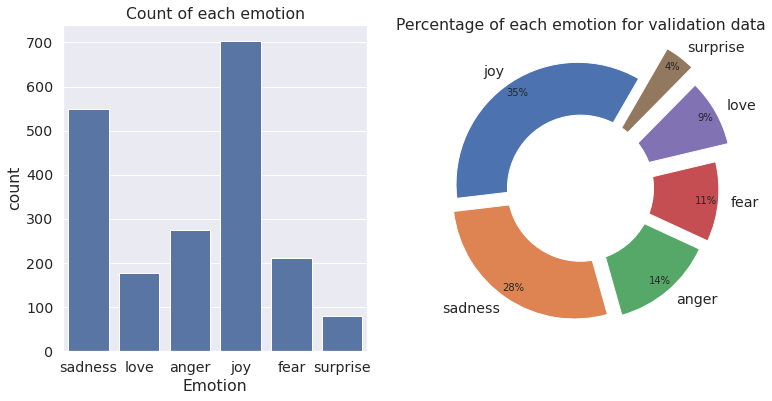

In [28]:
def plotting(df):
    col = 'Emotion'
    fig, (ax1, ax2)  = plt.subplots(nrows=1, ncols=2, figsize=(12,6))
    explode = list((np.array(list(df[col].dropna().value_counts()))/sum(list(df[col].dropna().value_counts())))[::-1])
    sizes = df[col].value_counts()
    labels = sizes.index
    #ax.pie(sizes, explode=explode, colors=bo, startangle=60, labels=labels,autopct='%1.0f%%', pctdistance=0.9)
    ax2.pie(sizes,  explode=explode, startangle=60, labels=labels,autopct='%1.0f%%', pctdistance=0.9)
    ax2.add_artist(plt.Circle((0,0),0.6,fc='white'))
    sns.countplot(x =col, data = df, ax=ax1)
    ax1.set_title("Count of each emotion")
    ax2.set_title("Percentage of each emotion for validation data")
    plt.show()

plotting(df_val)

In [29]:
#print the rows which are duplicated
df_val[df_val['Text'].duplicated() == True]

,Text,Emotion
603,i have had several new members tell me how com...,joy
1993,i feel so tortured by it,anger


In [30]:
#removing duplicated text
index = df_val[df_val['Text'].duplicated() == True].index
df_val.drop(index, axis = 0, inplace = True)
df_val.reset_index(inplace=True, drop = True)

In [31]:
#Count the number of stopwords in the data
temp =df_val.copy()
temp['stop_words'] = temp['Text'].apply(lambda x: len(set(x.split()) & set(stop_words)))
temp.stop_words.value_counts()[:10]

stop_words
7     190
5     175
8     173
6     160
3     160
10    150
9     146
4     145
2     133
11    103
Name: count, dtype: int64

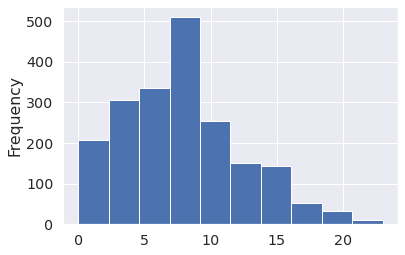

In [32]:
sns.set(font_scale=1.3)
temp['stop_words'].plot(kind= 'hist');

In [43]:
lm = WordNetLemmatizer()
def text_transformation(df_col):
    corpus = []
    for item in df_col:
        new_item = re.sub('[^a-zA-Z]',' ',str(item))
        new_item = new_item.lower()
        new_item = new_item.split()
        new_item = [lm.lemmatize(word) for word in new_item if word not in set(stopwords.words('english'))]
        corpus.append(' '.join(str(x) for x in new_item))
    return corpus
corpus = text_transformation(df_train['Text'])

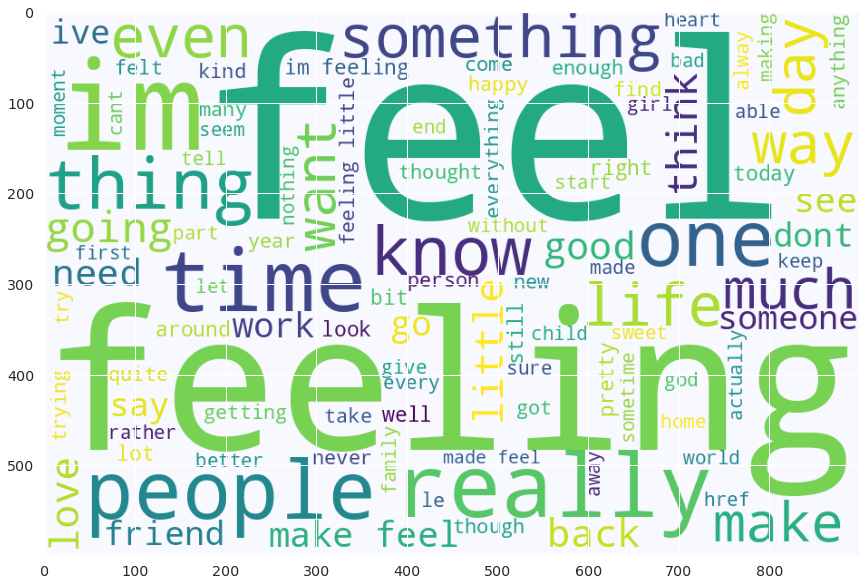

In [50]:
word_cloud = ""
for row in corpus:
    for word in row:
        word_cloud+=" ".join(word)
wordcloud = WordCloud(width = 900, height = 600,background_color ='ghostwhite',max_words=200, min_font_size = 20).generate(word_cloud)
plt.figure(figsize=(16, 10))
plt.imshow(wordcloud)

In [33]:
def dataframe_difference(df1, df2, which=None):
    """Find rows which are different between two DataFrames."""
    
    # Combine the two DataFrames using a merge operation, with the
    # indicator parameter set to True. This adds a column called _merge
    # to the resulting DataFrame, which indicates the source of each row.
    comparison_df = df1.merge(
        df2,
        indicator=True,
        how='outer'
    )
    
    # Filter the merged DataFrame based on the value of _merge. If which
    # is not specified, return all rows where _merge is not 'both'.
    # Otherwise, return all rows where _merge has the specified value
    if which is None:
        diff_df = comparison_df[comparison_df['_merge'] != 'both']
    else:
        diff_df = comparison_df[comparison_df['_merge'] == which]
        
    # Return the filtered DataFrame
    return diff_df

dataframe_difference(df_train, df_test, which='both')

,Text,Emotion,_merge


In [34]:
def lemmatization(text):
    lemmatizer= WordNetLemmatizer()
    text = text.split()
    text=[lemmatizer.lemmatize(y) for y in text]
    return " " .join(text)

# lemmatization("My Name is santosh. Plays cricket")

def remove_stop_words(text):
    Text=[i for i in str(text).split() if i not in stop_words]
    return " ".join(Text)

# remove_stop_words("My Name is santosh. Plays cricket")

def Removing_numbers(text):
    text=''.join([i for i in text if not i.isdigit()])
    return text
# Removing_numbers("My Name is santosh. Plays cricket 9 pm")

def lower_case(text):
    text = text.split()
    text=[y.lower() for y in text]
    return " " .join(text)
# lower_case("My Name is santosh; Plays cricket 9 pm !!!")

def Removing_punctuations(text):
    ## Remove punctuations
    text = re.sub('[%s]' % re.escape("""!"#$%&'()*+,،-./:;<=>؟?@[\]^_`{|}~"""), ' ', text)
    text = text.replace('؛',"", )
    
    ## remove extra whitespace
    text = re.sub('\s+', ' ', text)
    text =  " ".join(text.split())
    return text.strip()

# Removing_punctuations("My Name is santosh; Plays cricket 9 pm !!!")

def Removing_urls(text):
    url_pattern = re.compile(r'https?://\S+|www\.\S+')
    return url_pattern.sub(r'', text)

def remove_small_sentences(df):
    for i in range(len(df)):
        if len(df.text.iloc[i].split()) < 3:
            df.text.iloc[i] = np.nan

In [35]:
def normalize_text(df):
    df.Text=df.Text.apply(lambda text : lower_case(text))
    df.Text=df.Text.apply(lambda text : remove_stop_words(text))
    df.Text=df.Text.apply(lambda text : Removing_numbers(text))
    df.Text=df.Text.apply(lambda text : Removing_punctuations(text))
    df.Text=df.Text.apply(lambda text : Removing_urls(text))
    df.Text=df.Text.apply(lambda text : lemmatization(text))
    return df



In [36]:
def normalized_sentence(sentence):
    sentence= lower_case(sentence)
    sentence= remove_stop_words(sentence)
    sentence= Removing_numbers(sentence)
    sentence= Removing_punctuations(sentence)
    sentence= Removing_urls(sentence)
    sentence= lemmatization(sentence)
    return sentence


In [37]:
normalized_sentence("My Name is santosh; Plays cricket 9 pm !!!")

'name santosh play cricket pm'

In [38]:
df_train= normalize_text(df_train)
df_test= normalize_text(df_test)
df_val= normalize_text(df_val)

In [39]:
##TF-IDF¶
# The word counts suffer some issues: most frequent words are usually not important (like stop words),
# while they take high focus/count.TFIDF (Term Frequency - Inverse Document) is a way to adjust those counts:
# TF: #mentions within a document & IDF: #mentions across all docs

# So it gives higher importance to rare words across all docs (IDF++, TFIDF--), while it emphasyses on words 
# appearing mostly in THIS doc (TF++, TFIDF--). If a word appearing only in the current doc/sentence,
# it has TFIDF=1. If a word appears in all docs/sents but not the current one, it has TFIDF=0. 
# If a word (stop word for example) appearing a lot in the current doc/sent and also in ALL others, 
# it will have high TF (count) and much higher IDF (discount), so low TFIDF overall.

In [40]:
#Preprocessing text for TF-IDF

X_train = df_train['Text'].values
y_train = df_train['Emotion'].values

X_test = df_test['Text'].values
y_test = df_test['Emotion'].values

X_val = df_val['Text'].values
y_val = df_val['Emotion'].values

In [41]:
def train_model(model, data, targets):
    """
    Parameters:
    model (sklearn model): The model to be trained.
    data (list of str): The input data.
    targets (list of str): The targets.
    
    Returns:
    Pipeline: The trained model as a Pipeline object.
    """
    # Create a Pipeline object with a TfidfVectorizer and the given model
    text_clf = Pipeline([('vect',TfidfVectorizer()),
                         ('clf', model)])
    # Fit the model on the data and targets
    text_clf.fit(data, targets)
    return text_clf

In [51]:
def get_F1_score(trained_model,X,y):
    """    
    Parameters:
    trained_model (sklearn model): The trained model.
    X (list of str): The input data.
    y (list of str): The targets.
    
    Returns:
    array: The F1 score for each class.
    """
    # Make predictions on the input data using the trained model
    predicted=trained_model.predict(X)
    # Calculate the F1 score for the predictions
    f1=f1_score(y,predicted, average=None)
    # Return the F1 score
    return f1

In [52]:
###################### Logistic Regression ############################
#Train the model with the training data
log_reg = train_model(LogisticRegression(solver='liblinear',random_state = 0), X_train, y_train)

In [53]:
#Make a single prediction
y_pred=log_reg.predict(['Happy'])
y_pred

array(['joy'], dtype=object)

In [55]:
#test the model with the test data
y_pred=log_reg.predict(X_test)

#calculate the accuracy
log_reg_accuracy = accuracy_score(y_test, y_pred)
print('Accuracy: ', log_reg_accuracy,'\n')

#calculate the F1 score
f1_Score = get_F1_score(log_reg,X_test,y_test)
pd.DataFrame(f1_Score, index=df_train.Emotion.unique(), columns=['F1 score'])

Accuracy:  0.8685 



,F1 score
sadness,0.858223
anger,0.823810
love,0.893048
surprise,0.703704
fear,0.915683
joy,0.626263


In [56]:
##Classification Report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

       anger       0.89      0.83      0.86       275
        fear       0.88      0.77      0.82       224
         joy       0.83      0.96      0.89       695
        love       0.86      0.60      0.70       159
     sadness       0.90      0.93      0.92       581
    surprise       0.94      0.47      0.63        66

    accuracy                           0.87      2000
   macro avg       0.88      0.76      0.80      2000
weighted avg       0.87      0.87      0.86      2000



In [58]:
###################### Decission Tree ############################

#Train the model with the training data
Decission_tree = train_model(DecisionTreeClassifier(random_state = 0), X_train, y_train)

#test the model with the test data
y_pred=Decission_tree.predict(X_test)

#calculate the accuracy
decission_tree_accuracy = accuracy_score(y_test, y_pred)
print('Accuracy: ', decission_tree_accuracy,'\n')

#calculate the F1 score
f1_Score = get_F1_score(Decission_tree,X_test,y_test)
pd.DataFrame(f1_Score, index=df_train.Emotion.unique(), columns=['F1 score']) 

Accuracy:  0.859 



,F1 score
sadness,0.873440
anger,0.798206
love,0.890671
surprise,0.737805
fear,0.900605
joy,0.617647


In [59]:
##Classification Report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

       anger       0.86      0.89      0.87       275
        fear       0.80      0.79      0.80       224
         joy       0.90      0.88      0.89       695
        love       0.72      0.76      0.74       159
     sadness       0.90      0.90      0.90       581
    surprise       0.60      0.64      0.62        66

    accuracy                           0.86      2000
   macro avg       0.80      0.81      0.80      2000
weighted avg       0.86      0.86      0.86      2000



In [60]:
###################### Support Vector Mschine ############################

#Train the model with the training data
SVM = train_model(SVC(random_state = 0), X_train, y_train)

#test the model with the test data
y_pred=SVM.predict(X_test)

#calculate the accuracy
SVM_accuracy = accuracy_score(y_test, y_pred)
print('Accuracy: ', SVM_accuracy,'\n')

#calculate the F1 score
f1_Score = get_F1_score(SVM,X_test,y_test)
pd.DataFrame(f1_Score, index=df_train.Emotion.unique(), columns=['F1 score']) 

Accuracy:  0.8675 



,F1 score
sadness,0.857685
anger,0.827907
love,0.893645
surprise,0.681648
fear,0.914821
joy,0.654206


In [61]:
##Classification Report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

       anger       0.90      0.82      0.86       275
        fear       0.86      0.79      0.83       224
         joy       0.83      0.96      0.89       695
        love       0.84      0.57      0.68       159
     sadness       0.91      0.92      0.91       581
    surprise       0.85      0.53      0.65        66

    accuracy                           0.87      2000
   macro avg       0.87      0.77      0.80      2000
weighted avg       0.87      0.87      0.86      2000



In [62]:
###################### Random Forest Classifier ############################

#Train the model with the training data
random_forest = train_model(RandomForestClassifier(random_state = 0), X_train, y_train)

#test the model with the test data
y_pred=random_forest.predict(X_test)

#calculate the accuracy
random_forest_accuracy = accuracy_score(y_test, y_pred)
print('Accuracy: ', random_forest_accuracy,'\n')

#calculate the F1 score
f1_Score = get_F1_score(random_forest, X_test, y_test)
pd.DataFrame(f1_Score, index=df_train.Emotion.unique(), columns=['F1 score']) 

Accuracy:  0.8895 



,F1 score
sadness,0.903811
anger,0.868421
love,0.908199
surprise,0.738983
fear,0.933798
joy,0.634146


In [63]:
##Classification Report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

       anger       0.90      0.91      0.90       275
        fear       0.85      0.88      0.87       224
         joy       0.89      0.93      0.91       695
        love       0.80      0.69      0.74       159
     sadness       0.95      0.92      0.93       581
    surprise       0.68      0.59      0.63        66

    accuracy                           0.89      2000
   macro avg       0.85      0.82      0.83      2000
weighted avg       0.89      0.89      0.89      2000



In [64]:
models = pd.DataFrame({
    'Model': ['Logistic Regression', 'Decision Tree','Support Vector Machine','Random Forest'],
    'Accuracy': [log_reg_accuracy.round(2), decission_tree_accuracy.round(2), SVM_accuracy.round(2), random_forest_accuracy.round(2)]})

models.sort_values(by='Accuracy', ascending=False).reset_index().drop(['index'], axis=1)

,Model,Accuracy
0,Random Forest,0.89
1,Logistic Regression,0.87
2,Support Vector Machine,0.87
3,Decision Tree,0.86


In [68]:
explainer_LR = LimeTextExplainer(class_names=random_forest.classes_)
idx  = 22
print("Actual Text : ", X_test[idx])
print("Prediction : ", random_forest.predict(X_test)[idx])
print("Actual :     ", y_test[idx])
exp = explainer_LR.explain_instance(X_test[idx], random_forest.predict_proba,top_labels=5)
exp.show_in_notebook()

Actual Text :  survey post last year feel pleased vague snippet feel little bit capture like someone like dublin st century
Prediction :  joy
Actual :      joy


In [69]:
## Word embedding using Glove and use a LSTM

In [70]:
#Splitting the text from the labels
X_train = df_train['Text']
y_train = df_train['Emotion']

X_test = df_test['Text']
y_test = df_test['Emotion']

X_val = df_val['Text']
y_val = df_val['Emotion']

In [142]:
# Encode labels
le = LabelEncoder()
y_train = le.fit_transform(y_train)
y_test = le.transform(y_test)
y_val = le.transform(y_val)
#print the labels after encoding 
# print(set(y_train))

In [73]:
#Convert the class vector (integers) to binary class matrix
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)
y_val = to_categorical(y_val)

print(y_train)

[[0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 1. 0.]
 [1. 0. 0. 0. 0. 0.]
 ...
 [0. 0. 1. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0.]]


In [78]:
# Tokenize words
tokenizer = Tokenizer(oov_token='UNK')
tokenizer.fit_on_texts(pd.concat([X_train, X_test], axis=0))
# tokenizer.word_counts      ## A dictionary of words and their counts.
# tokenizer.document_count   ## Total number of rows

In [81]:
tokenizer.word_index['pathetic']

495

In [83]:
#converting a single sentence to list of indexes
tokenizer.texts_to_sequences(X_train[53].split())

[[7107], [11], [24], [940], [3], [359], [135], [31], [1016], [211], [7108]]

In [87]:
#convert the list of indexes into a matrix of ones and zeros (BOW)
tokenizer.texts_to_matrix(X_train[53].split()).shape

(11, 14325)

In [91]:
sequences_train = tokenizer.texts_to_sequences(X_train)
sequences_test = tokenizer.texts_to_sequences(X_test)
sequences_val = tokenizer.texts_to_sequences(X_val)
sequences_train

[[53, 2, 531],
 [31, 3, 421, 3445, 435, 45, 56, 176, 1223],
 [5, 2719, 393, 147, 2, 355, 302],
 [74, 3, 586, 4092, 8, 20, 3446],
 [3, 994],
 [21, 3, 11, 436, 226, 227, 65],
 [21, 247, 7092, 6, 7093, 755, 21, 2451, 1312, 54, 1669, 41, 2, 4, 352],
 [2, 338, 18, 1313, 693, 44, 170, 277],
 [5084, 44, 2, 5084, 5085, 51, 46, 914, 3015],
 [2, 568],
 [2, 4, 10, 628, 452, 138, 25],
 [2, 356, 422, 252, 891, 647, 1765, 2452],
 [19, 5086, 6, 44, 2, 508],
 [2, 258, 347, 4093],
 [4094,
  1460,
  892,
  130,
  694,
  7094,
  937,
  87,
  68,
  6,
  127,
  1461,
  18,
  1462,
  3447,
  90,
  108,
  2453,
  3016,
  2,
  11,
  423],
 [2, 695, 915, 322],
 [53, 7, 2, 323],
 [2, 35, 495, 6],
 [92, 3, 827, 2454, 103, 475, 1870, 2102, 5087, 2454, 5088],
 [2, 3448, 796, 1123, 60, 3017, 40, 137],
 [2, 378, 437, 79, 149, 71, 278, 71],
 [3,
  174,
  134,
  124,
  2264,
  49,
  2,
  1871,
  2455,
  105,
  1596,
  1314,
  1035,
  119,
  115,
  557,
  965,
  15,
  637],
 [3, 828, 829],
 [97, 49, 5089, 5090, 453, 30

In [92]:
## Padding 
## The vectors we obtained from the above are not in equal lengths
## So we need to add padding to its max length. 

In [97]:
maxlen = max([len(t) for t in df_train['Text']])
maxlen

229

In [98]:
X_train = pad_sequences(sequences_train, maxlen=229, truncating='pre')
X_test = pad_sequences(sequences_test, maxlen=229, truncating='pre')
X_val = pad_sequences(sequences_val, maxlen=229, truncating='pre')

vocabSize = len(tokenizer.index_word) + 1
print(f"Vocabulary size = {vocabSize}")

Vocabulary size = 14325


In [ ]:
## Word embeddings
# path_to_glove_file: The file path to the GloVe word vectors file.

# num_tokens: The size of the vocabulary. This is typically the number of unique words in the dataset.

# embedding_dim: The dimensionality of the word vectors. This is usually set to a fixed value (e.g., 200, 300, etc.)
# depending on the size of the word vectors file that is being used.

# hits: A counter for the number of words that are found in the embeddings_index dictionary.

# misses: A counter for the number of words that are not found in the embeddings_index dictionary.

# embeddings_index: A dictionary that will store the word vectors, with the words as keys and 
# the word vectors as values.

In [102]:
# Reading GloVE embeddings

path_to_glove_file = '/home/santosh/sentiment/glove.6B.200d.txt'
num_tokens = vocabSize
embedding_dim = 200 #latent factors or features  
hits = 0
misses = 0
embeddings_index = {}

In [103]:
# Read word vectors
with open(path_to_glove_file) as f:
    for line in f:
        word, coefs = line.split(maxsplit=1)
        coefs = np.fromstring(coefs, "f", sep=" ")
        embeddings_index[word] = coefs
print("Found %s word vectors." % len(embeddings_index))

# Assign word vectors to our dictionary/vocabulary
embedding_matrix = np.zeros((num_tokens, embedding_dim))
for word, i in tokenizer.word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # Words not found in embedding index will be all-zeros.
        # This includes the representation for "padding" and "OOV"
        embedding_matrix[i] = embedding_vector
        hits += 1
    else:
        misses += 1
print("Converted %d words (%d misses)" % (hits, misses))

Found 400000 word vectors.
Converted 13243 words (1081 misses)


In [106]:
# Build neural network architecture

adam = Adam(learning_rate=0.005)

model = Sequential()
model.add(Embedding(vocabSize, 200, input_length=X_train.shape[1], weights=[embedding_matrix], trainable=False))
model.add(Bidirectional(LSTM(256, dropout=0.2,recurrent_dropout=0.2, return_sequences=True)))
model.add(Bidirectional(LSTM(128, dropout=0.2,recurrent_dropout=0.2, return_sequences=True)))
model.add(Bidirectional(LSTM(128, dropout=0.2,recurrent_dropout=0.2)))
# model.add(Bidirectional(LSTM(64, dropout=0.2,recurrent_dropout=0.2, return_sequences=True)))
# model.add(Bidirectional(LSTM(64, dropout=0.2,recurrent_dropout=0.2)))
model.add(Dense(6, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 229, 200)          2865000   
                                                                 
 bidirectional_8 (Bidirecti  (None, 229, 512)          935936    
 onal)                                                           
                                                                 
 bidirectional_9 (Bidirecti  (None, 229, 256)          656384    
 onal)                                                           
                                                                 
 bidirectional_10 (Bidirect  (None, 256)               394240    
 ional)                                                          
                                                                 
 dense_2 (Dense)             (None, 6)                 1542      
                                                      

In [107]:
# An Embedding layer that takes in integer-encoded text and looks up the embedding vector for each word in 
# the input. The input length is set to the length of the input sequences, and the weights are initialized with 
# an embedding matrix that has been pre-trained on a large dataset. The embedding layer is not trainable, 
# meaning that the weights of this layer will not be updated during training.

# Three Bidirectional layers, each of which applies a forward and backward LSTM to the input. 
# LSTMs are a type of recurrent neural network that are able to capture long-term dependencies in sequential data. 
# The dropout and recurrent dropout arguments specify the dropout rate to apply to the inputs and 
# recurrent inputs of the LSTMs, respectively. The return_sequences argument specifies whether the LSTM should 
# return the full sequences of outputs or just the last output of each sequence.

# A Dense layer that applies a linear transformation to the input to produce the output. The output has 6 units 
# and uses the 'softmax' activation function, which means that it will output a probability distribution over 
# the 6 classes.

In [108]:
# The first layer is an "Embedding" layer, which takes in integer-encoded text and looks up the embedding vector 
# for each word in the input. The output of this layer is a 3D tensor with shape 
# (batch_size, sequence_length, embedding_dim), where batch_size is the number of examples in the batch, 
# sequence_length is the length of the input sequences, and embedding_dim is the size of the embedding vectors. 
# In this case, the input sequences are 229 words long and the embedding vectors are 200 dimensions. 
# The embedding layer has a total of 2,863,600 trainable parameters.

# The next three layers are "Bidirectional" layers, which apply a forward and backward LSTM to the input. 
# LSTMs are a type of recurrent neural network that are able to capture long-term dependencies in sequential data. 
# The output of each bidirectional layer is a 3D tensor with shape (batch_size, sequence_length, units), 
# where units is the number of LSTM units in the layer. In this case, the first bidirectional layer has 512 units,
# the second has 256 units, and the third has 256 units. Each of these layers has a large number of trainable 
# parameters, as LSTMs are complex models with many internal weights.

# The final layer is a "Dense" layer, which applies a linear transformation to the input to produce the output. 
# In this case, the output has shape (batch_size, 6), indicating that there are 6 classes. 
# The dense layer has a total of 1,542 trainable parameters.

# Overall, the model has a total of 4,851,702 trainable parameters and 2,863,600 non-trainable parameters

In [116]:
from keras.utils.vis_utils import plot_model

plot_model(model, show_shapes=True)

ModuleNotFoundError: No module named 'keras.utils.vis_utils'

In [118]:
# !pip3 freeze

In [119]:
#to stop the training when the loss starts to increase
callback = EarlyStopping(
    monitor="val_loss",
    patience=5,
    restore_best_weights=True,
)

In [122]:
# Fit model
history = model.fit(X_train,
                    y_train,
                    validation_data=(X_val, y_val),
                    verbose=1,
                    batch_size=64,
                    epochs=30,
                    callbacks=[callback]
                   )

Epoch 1/30
250/250 [==============================] - 2064s 8s/step - loss: 0.7359 - accuracy: 0.7389 - val_loss: 0.2958 - val_accuracy: 0.9024
Epoch 2/30
250/250 [==============================] - 2065s 8s/step - loss: 0.2184 - accuracy: 0.9126 - val_loss: 0.1443 - val_accuracy: 0.9244
Epoch 3/30
250/250 [==============================] - 2058s 8s/step - loss: 0.1407 - accuracy: 0.9317 - val_loss: 0.1921 - val_accuracy: 0.9184
Epoch 4/30
250/250 [==============================] - 2069s 8s/step - loss: 0.1174 - accuracy: 0.9408 - val_loss: 0.1354 - val_accuracy: 0.9344
Epoch 5/30
250/250 [==============================] - 2065s 8s/step - loss: 0.1081 - accuracy: 0.9411 - val_loss: 0.1374 - val_accuracy: 0.9314
Epoch 6/30
250/250 [==============================] - 2066s 8s/step - loss: 0.1020 - accuracy: 0.9464 - val_loss: 0.1338 - val_accuracy: 0.9289
Epoch 7/30
250/250 [==============================] - 2067s 8s/step - loss: 0.0947 - accuracy: 0.9492 - val_loss: 0.1215 - val_accuracy:

In [123]:
model.evaluate(X_val, y_val, verbose=1) 

63/63 [==============================] - 62s 990ms/step - loss: 0.1215 - accuracy: 0.9359


[0.12152345478534698, 0.935935914516449]

In [124]:
model.evaluate(X_test, y_test, verbose=1) 

63/63 [==============================] - 62s 991ms/step - loss: 0.1319 - accuracy: 0.9330


[0.1319434940814972, 0.9330000281333923]

In [126]:
predicted = model.predict(X_test)
y_pred = predicted.argmax(axis=-1)


63/63 [==============================] - 62s 983ms/step


In [128]:
# Loss & Accuracy graph

%matplotlib inline
import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

<Figure size 432x288 with 0 Axes>

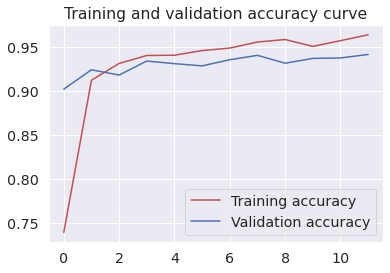

<Figure size 432x288 with 0 Axes>

In [129]:
plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy curve')
plt.legend()
plt.figure()

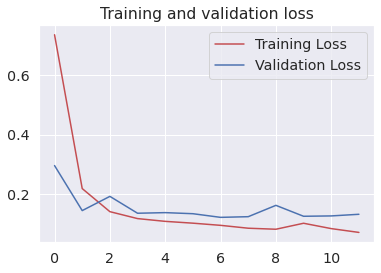

In [130]:
plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [131]:
## Now if user gives input to the model then how it will work? 

In [132]:
# First, the model will convert the words in the sentence into numerical representations, 
# also known as word embeddings. These word embeddings capture the meaning of the words and their relationships 
# to each other in a continuous vector space.

# The word embeddings for each word in the sentence are then input to two separate LSTM models: one that processes 
# the sequence forwards and one that processes it backwards. At each time step, each LSTM processes the current word 
# embedding and the previous hidden state to produce a new hidden state. The hidden state at each time step is a 
# combination of the previous hidden state and the current input, and it captures the information from all the 
# previous time steps in the sequence.

# After processing all the words in the sentence, the two LSTMs will have final hidden states that encode the 
# meaning of the sentence from both the forwards and backwards directions. These final hidden states are then 
# combined and used to make a prediction.

In [135]:
# Classify custom sample

sentences = [
            "He's over the moon about being accepted to the university",
            "Your point on this certain matter made me outrageous, how can you say so? This is insane.",
            "I can't do it, I'm not ready to lose anything, just leave me alone",
            "Merlin's beard harry, you can cast the Patronus charm! I'm amazed!"
            ]

for sentence in sentences:
    print(sentence)
    sentence = normalized_sentence(sentence)
    sentence = tokenizer.texts_to_sequences([sentence])
    sentence = pad_sequences(sentence, maxlen=229, truncating='pre')
    result = le.inverse_transform(np.argmax(model.predict(sentence), axis=-1))[0]
    proba =  np.max(model.predict(sentence))
    print(f"{result} : {proba}\n\n")

He's over the moon about being accepted to the university
1/1 [==============================] - 1s 959ms/step
2 : 0.960789144039154


Your point on this certain matter made me outrageous, how can you say so? This is insane.
1/1 [==============================] - 1s 963ms/step
0 : 0.7553593516349792


I can't do it, I'm not ready to lose anything, just leave me alone
1/1 [==============================] - 1s 963ms/step
0 : 0.5113371014595032


Merlin's beard harry, you can cast the Patronus charm! I'm amazed!
1/1 [==============================] - 1s 972ms/step
5 : 0.8798438310623169




In [145]:
### Labels ###
# 0:Fear
# 1:sadnes
# 2:Joy
# 3:anger
# 5:Surprise
# 4:love

In [144]:
model.save('Sentiment_analysis_Eng-V1.h5')

/home/santosh/.local/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
